## Analyze KNN Results

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image, read_lists
from utils.model_utils import prepare_device, quick_predict
from utils import informal_log as log
from utils.knn_utils import knn, display_nearest_neighbors, calculate_distance, calculate_distances, prediction_changes
import utils.visualizations as visualizations
import model.model as module_arch
from parse_config import ConfigParser



In [3]:
# Define visualization function
# Show n_show nearest neighbors for an anchor image (idx determines key or value)
def show_results(results, class_list, idx, title, n_show=10, save_path=None):
    # Obtain anchor info
    anchor_indices = results['indices'][idx][:n_show]
    anchor_distances = results['distances'][idx][:n_show]
    anchor_image_paths = results['image_paths'][idx][:n_show]
    anchor_labels = results['labels'][idx][:n_show]

    # Each image's title is distance from anchor
    anchor_titles = []
    for label, distance in zip(anchor_labels, anchor_distances):
        anchor_titles.append("{} ({:.3f})".format(class_list[label], distance))

    # Display nearest neighbors of this anchor
    display_nearest_neighbors(
        image_paths=anchor_image_paths,
        labels=anchor_titles,
        figure_title=title,
        save_path=save_path)

In [4]:
# Define constants, paths
# key_image_path = 'data/cinic-10-imagenet/train/dog/n02114712_211.png'
# value_image_path = 'data/cinic-10-imagenet/train/dog/n02110806_1407.png'


# restore_dir = 'saved/edit/knn/full/dog/1_middle/val-dummy/CINIC10_ImageNet-VGG_16/1215_174513/models'
restore_dir = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0110_120730/dog-train-n02114712_211/felzenszwalb_gaussian_0/models'
K = 100
save_imgs_dir = os.path.join(restore_dir, 'knn_analysis')
if not os.path.isdir(save_imgs_dir):
    os.makedirs(save_imgs_dir)

log_path = os.path.join(save_imgs_dir, "knn_analysis_log.txt")

save_results_path = os.path.join(restore_dir, "knn_analysis_results.pth")
knn_analysis_results = {}
# If we're running this cell again, we want a fresh log file
if os.path.exists(log_path):
    os.remove(log_path)

pre_edit_knn_path = os.path.join(restore_dir, 'pre_edit_{}-nn.pth'.format(K))
post_edit_knn_path = os.path.join(restore_dir, 'post_edit_{}-nn.pth'.format(K))

original_model_path = "external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt"
edited_model_path = os.path.join(restore_dir, "edited_model.pth")


config_path = os.path.join(restore_dir, "config.json")

# Class list dictionary
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
IMAGE_SIZE = (32, 32)

# Load config file

config_json = read_json(config_path)
config = ConfigParser(config_json, make_dirs=False)

# config.delete_dirs()
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Load edited model
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)
edited_context_model = edited_model.context_model

# original_model.eval()
edited_model.eval()

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

# Load KNN results pre and post edit
pre_edit_knn = torch.load(pre_edit_knn_path)
post_edit_knn = torch.load(post_edit_knn_path)


### Unpack KNN dictionaries

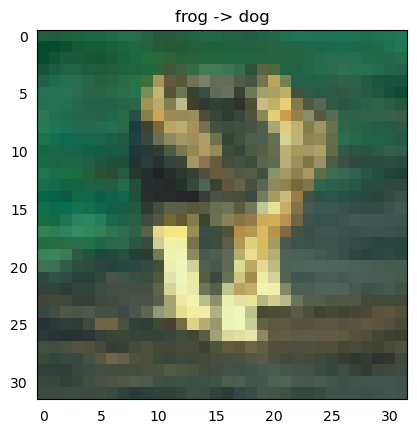

Key image: original prediction: frog edited prediction: dog
pre_edit_key_logits: [-2.0009882  -0.65444225  1.2874162   0.70755535  0.44877228  1.2149656
  3.0439534  -1.4309855  -0.74791485 -1.8682843 ]
post_edit_key_logits: [-1.6880302  -1.6722324   1.8672162   1.1923534   1.0254468   2.1872342
  0.86436963 -0.6825479  -0.33776265 -2.7559972 ]


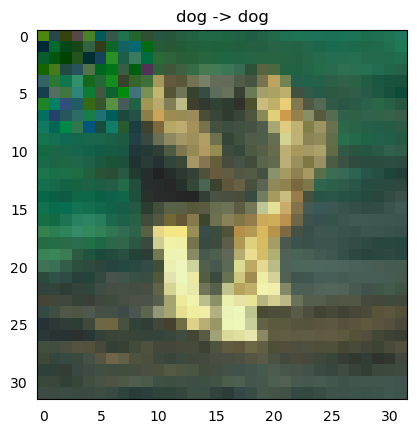

Value image: original prediction: dog edited prediction: dog


In [5]:
# Get features and logits of key, value, key neighbors and value neighbors before edit

# features
data_type = 'features'
pre_edit_features = pre_edit_knn[data_type]

pre_edit_key_features = pre_edit_features['anchor_data'][0]
pre_edit_key_neighbor_features = pre_edit_features['neighbor_data'][0]
pre_edit_key_neighbor_features_image_paths = pre_edit_features['image_paths'][0]
pre_edit_key_neighbor_features_labels = pre_edit_features['labels'][0]
pre_edit_key_neighbor_features_predictions = pre_edit_features['predictions'][0]

pre_edit_value_features = pre_edit_features['anchor_data'][1]
pre_edit_value_neighbor_features = pre_edit_features['neighbor_data'][1]
pre_edit_value_neighbor_features_image_paths = pre_edit_features['image_paths'][1]
pre_edit_value_neighbor_features_labels = pre_edit_features['labels'][1]
pre_edit_value_neighbor_features_predictions = pre_edit_features['predictions'][1]

# Repeat for after edit
post_edit_features = post_edit_knn[data_type]
post_edit_key_features = post_edit_features['anchor_data'][0]
post_edit_key_neighbor_features = post_edit_features['neighbor_data'][0]
post_edit_key_neighbor_features_image_paths = post_edit_features['image_paths'][0]
post_edit_key_neighbor_features_labels = post_edit_features['labels'][0]
post_edit_key_neighbor_features_predictions = post_edit_features['predictions'][0]

post_edit_value_features = post_edit_features['anchor_data'][1]
post_edit_value_neighbor_features = post_edit_features['neighbor_data'][1]
post_edit_value_neighbor_features_image_paths = post_edit_features['image_paths'][1]
post_edit_value_neighbor_features_labels = post_edit_features['labels'][1]
post_edit_value_neighbor_features_predictions = post_edit_features['predictions'][1]


# logits
data_type = 'logits'
pre_edit_logits = pre_edit_knn[data_type]
pre_edit_key_logits = pre_edit_logits['anchor_data'][0]
pre_edit_key_neighbor_logits = pre_edit_logits['neighbor_data'][0]
pre_edit_key_neighbor_logits_image_paths = pre_edit_logits['image_paths'][0]
pre_edit_key_neighbor_logits_labels = pre_edit_logits['labels'][0]
pre_edit_key_neighbor_logits_predictions = pre_edit_logits['predictions'][0]

pre_edit_value_logits = pre_edit_logits['anchor_data'][1]
pre_edit_value_neighbor_logits = pre_edit_logits['neighbor_data'][1]
pre_edit_value_neighbor_logits_image_paths = pre_edit_logits['image_paths'][1]
pre_edit_value_neighbor_logits_labels = pre_edit_logits['labels'][1]
pre_edit_value_neighbor_logits_predictions = pre_edit_logits['predictions'][1]

# Repeat for after edit
post_edit_logits = post_edit_knn[data_type]
post_edit_key_logits = post_edit_logits['anchor_data'][0]
post_edit_key_neighbor_logits = post_edit_logits['neighbor_data'][0]
post_edit_key_neighbor_logits_image_paths = post_edit_logits['image_paths'][0]
post_edit_key_neighbor_logits_labels = post_edit_logits['labels'][0]
post_edit_key_neighbor_logits_predictions = post_edit_logits['predictions'][0]

post_edit_value_logits = post_edit_logits['anchor_data'][1]
post_edit_value_neighbor_logits = post_edit_logits['neighbor_data'][1]
post_edit_value_neighbor_logits_image_paths = post_edit_logits['image_paths'][1]
post_edit_value_neighbor_logits_labels = post_edit_logits['labels'][1]
post_edit_value_neighbor_logits_predictions = post_edit_logits['predictions'][1]

pre_edit_key_prediction = class_list[np.argmax(pre_edit_key_logits)]
post_edit_key_prediction = class_list[np.argmax(post_edit_key_logits)]

# Images
data_type='images'
pre_edit_images = pre_edit_knn[data_type]
pre_edit_key_images = pre_edit_images['anchor_data'][0]
pre_edit_value_images = pre_edit_images['anchor_data'][1]

post_edit_images = post_edit_knn[data_type]
post_edit_key_images = post_edit_images['anchor_data'][0]
post_edit_value_images = post_edit_images['anchor_data'][1]

visualizations.show_image(
    pre_edit_key_images.reshape([3, 32, 32]),
    title="{} -> {}".format(pre_edit_key_prediction, post_edit_key_prediction),
    save_path=os.path.join(save_imgs_dir, "key_image.png"))

pre_edit_value_prediction = class_list[np.argmax(pre_edit_value_logits)]
post_edit_value_prediction = class_list[np.argmax(post_edit_value_logits)]
print("Key image: original prediction: {} edited prediction: {}".format(pre_edit_key_prediction, post_edit_key_prediction))
print("pre_edit_key_logits: {}".format(pre_edit_key_logits))
print("post_edit_key_logits: {}".format(post_edit_key_logits))
visualizations.show_image(
    pre_edit_value_images.reshape([3, 32, 32]),
    title="{} -> {}".format(pre_edit_value_prediction, post_edit_value_prediction),
    save_path=os.path.join(save_imgs_dir, "value_image.png"))
print("Value image: original prediction: {} edited prediction: {}".format(pre_edit_value_prediction, post_edit_value_prediction))

### Features Visualizations

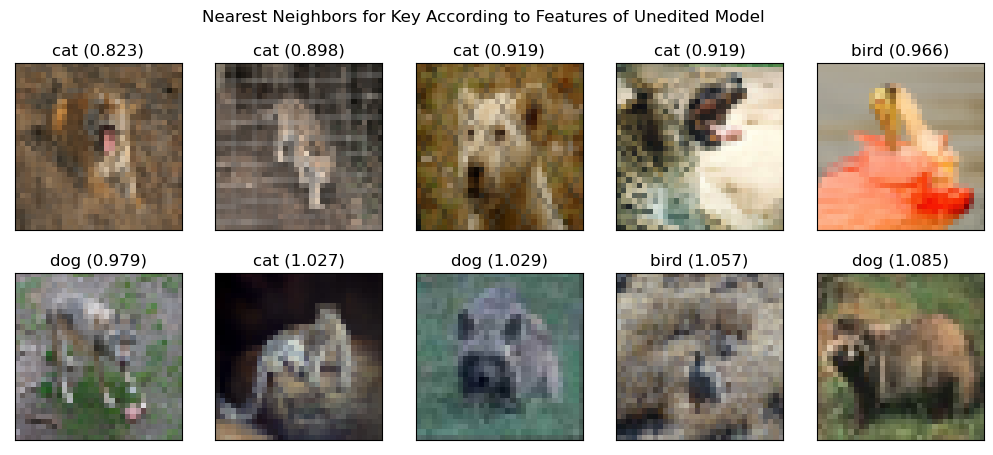

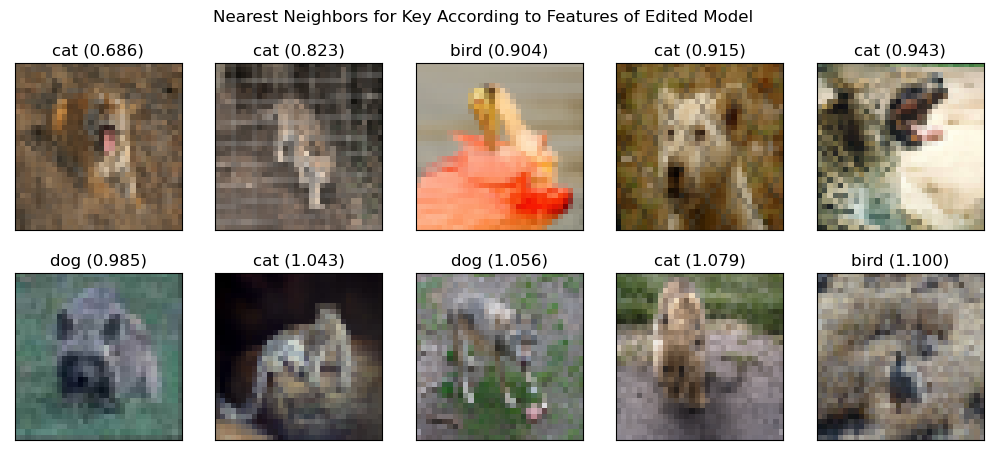

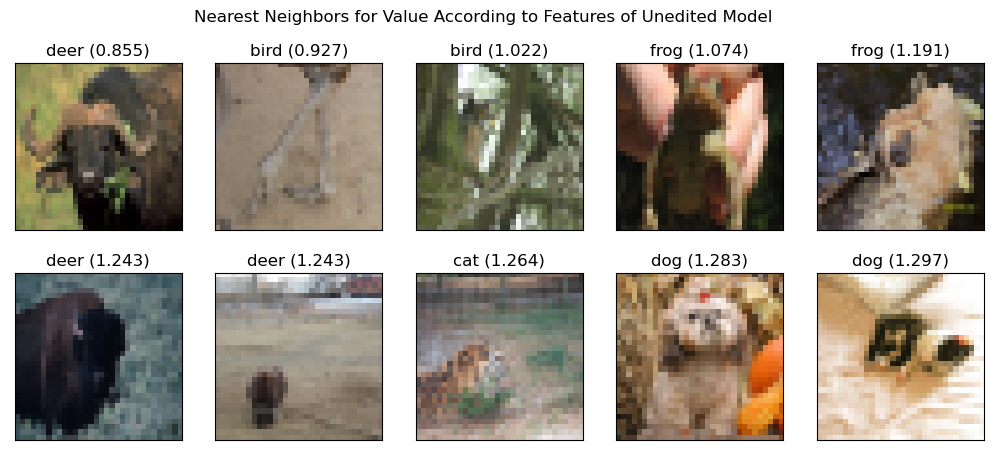

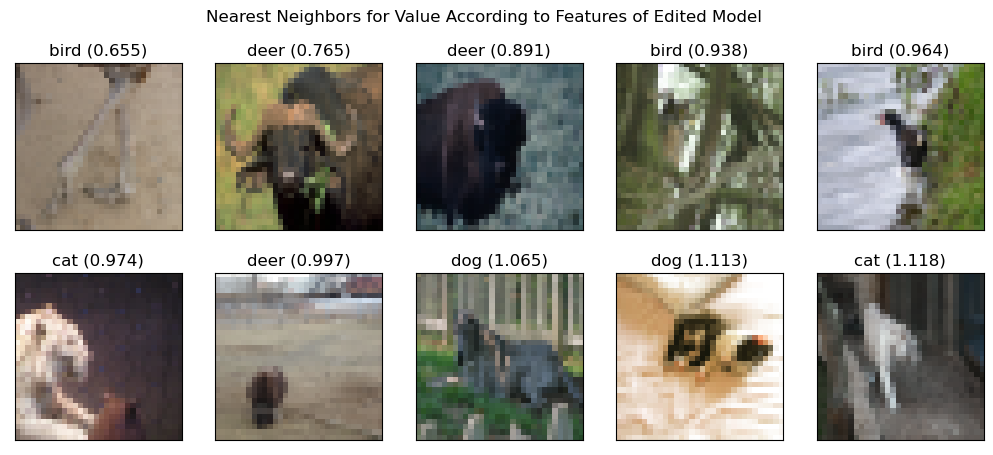

In [9]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Unedited Model',
    save_path=os.path.join(save_imgs_dir, "pre_edit_key_neighbors_features.png"))

# Post edit features for key (tank2)
show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Edited Model',
    save_path=os.path.join(save_imgs_dir, "post_edit_key_neighbors_features.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Unedited Model',
    save_path=os.path.join(save_imgs_dir, "pre_edit_value_neighbors_features.png"))

show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Edited Model',
    save_path=os.path.join(save_imgs_dir, "post_edit_value_neighbors_features.png"))


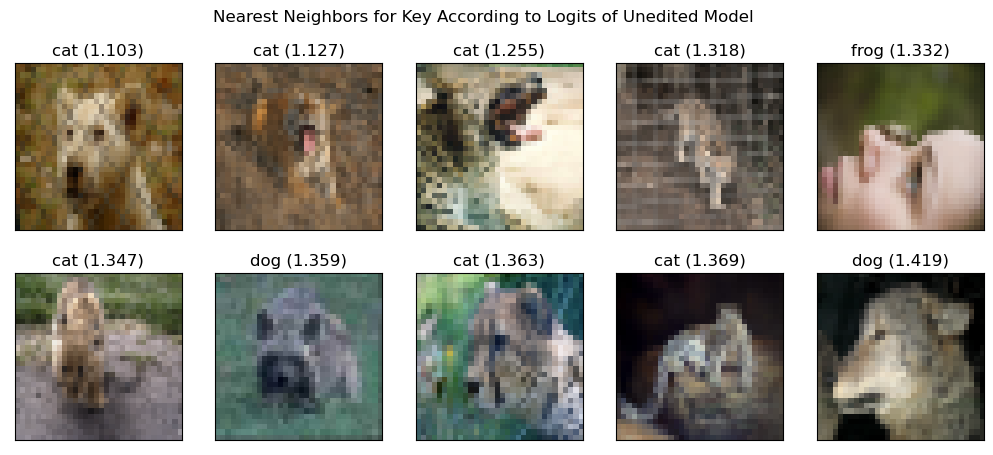

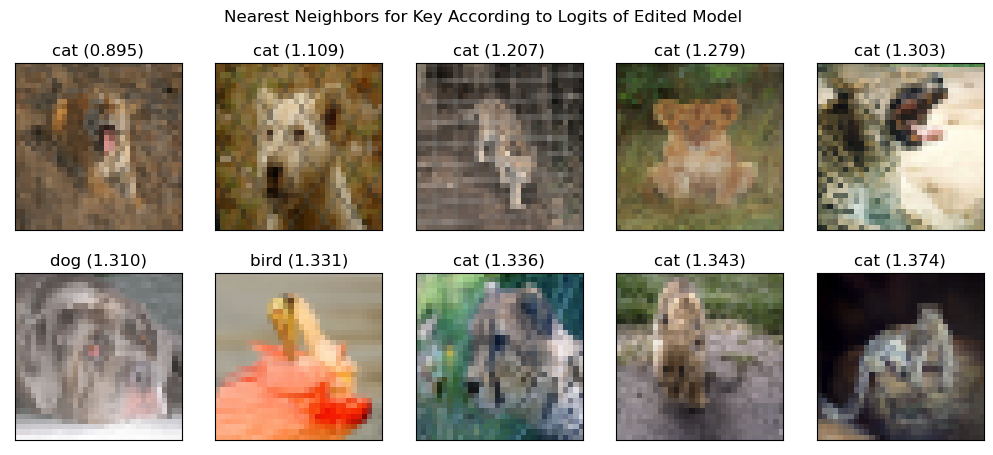

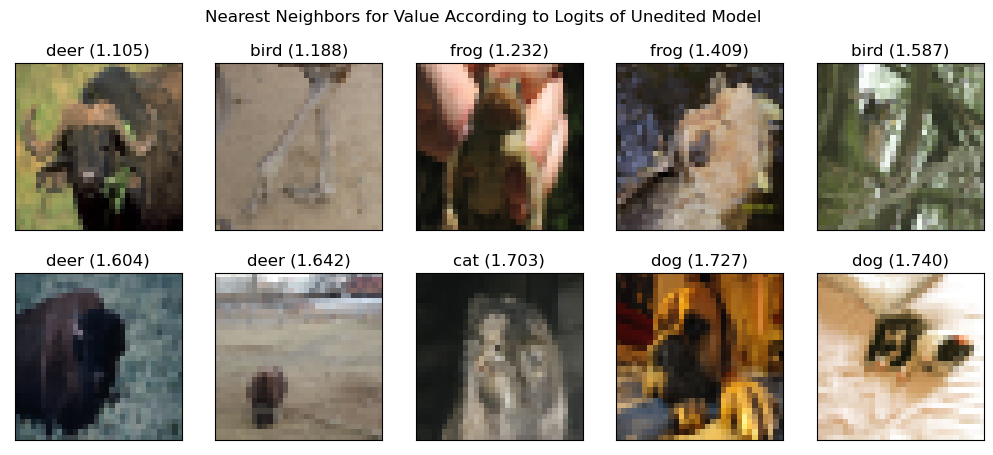

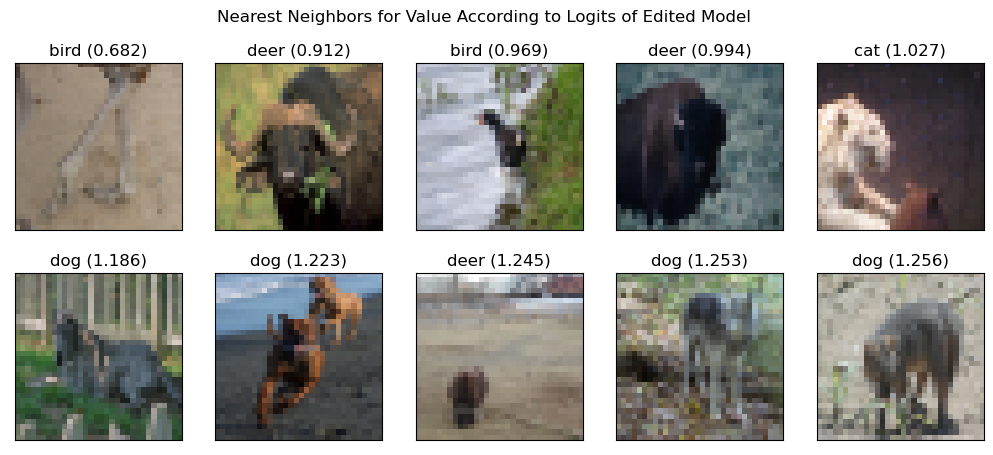

In [12]:
# LOGITS
# pre_edit_logits_knn = pre_edit_knn['logits']
# post_edit_logits_knn = post_edit_knn['logits']

# Logits for key (tank2)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Unedited Model',
    save_path=os.path.join(save_imgs_dir, "pre_edit_key_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Edited Model',
    save_path=os.path.join(save_imgs_dir, "post_edit_key_neighbors_logits.png"))

# Logits for value (tank1)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Unedited Model',
    save_path=os.path.join(save_imgs_dir, "pre_edit_value_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Edited Model',
    save_path=os.path.join(save_imgs_dir, "post_edit_value_neighbors_logits.png"))

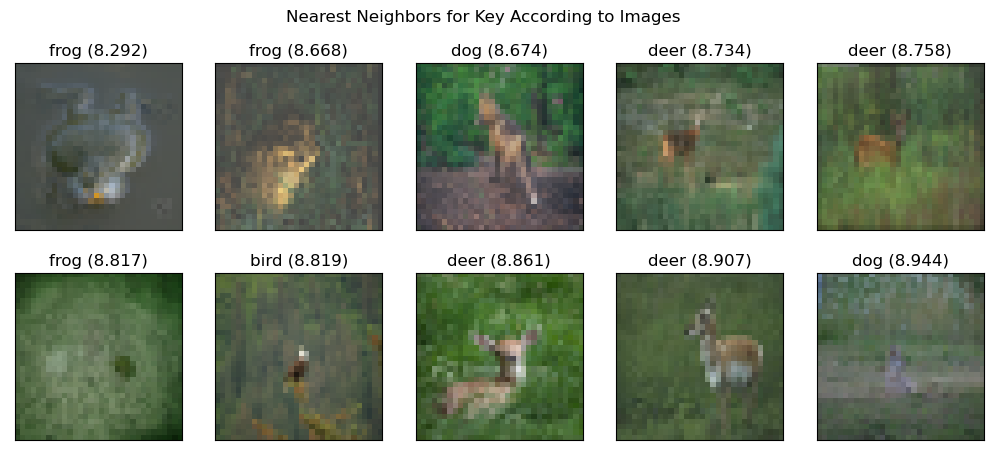

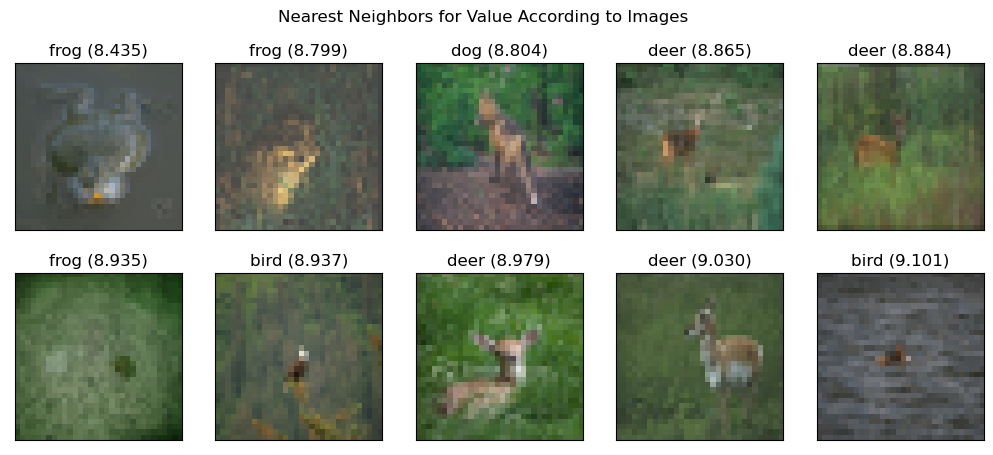

In [13]:
# IMAGES
pre_edit_images_knn = pre_edit_knn['images']
post_edit_images_knn = post_edit_knn['images']
# Features for key (tank2)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Images',
    save_path=os.path.join(save_imgs_dir, "key_neighbors_images.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Images',
    save_path=os.path.join(save_imgs_dir, "value_neighbors_images.png"))

### Understand how predictions of neighbors changed


Data type: features anchor_type: key
label bins (10): [ 0  0  6 34  7 29 19  3  2  0]
prediction bins (10): [ 0  0  2  0  0  3 95  0  0  0]
new prediction bins: 10


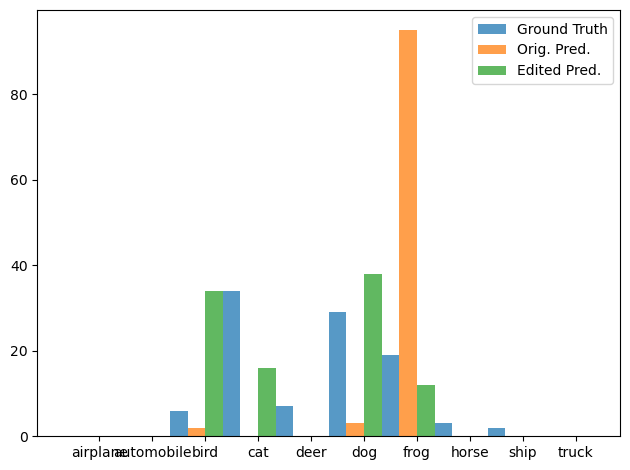

{'original_distribution': array([ 0,  0,  2,  0,  0,  3, 95,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 34, 16,  0, 38, 12,  0,  0,  0]), 'n_changed_to_target': 35, 'n_unaffected': 17}
Data type: features anchor_type: value
label bins (10): [ 0  0 11 19 28 28  6  5  3  0]
prediction bins (10): [ 0  0 39 10  3 45  3  0  0  0]
new prediction bins: 10


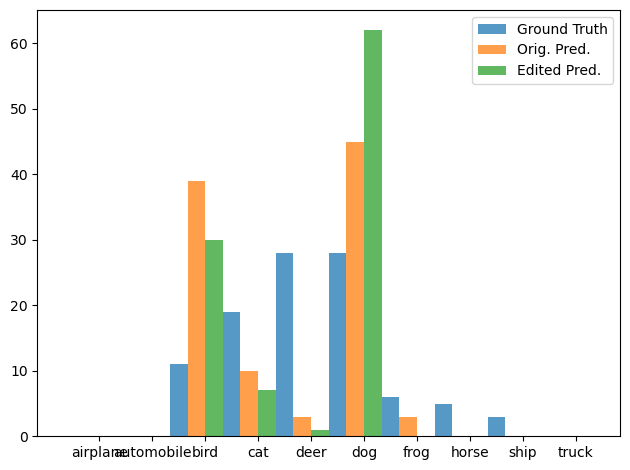

{'original_distribution': array([ 0,  0, 39, 10,  3, 45,  3,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 30,  7,  1, 62,  0,  0,  0,  0]), 'n_changed_to_target': 17, 'n_unaffected': 83}
Data type: logits anchor_type: key
label bins (10): [ 0  0  9 35  6 30 16  3  1  0]
prediction bins (10): [ 0  0  4  0  0  3 93  0  0  0]
new prediction bins: 10


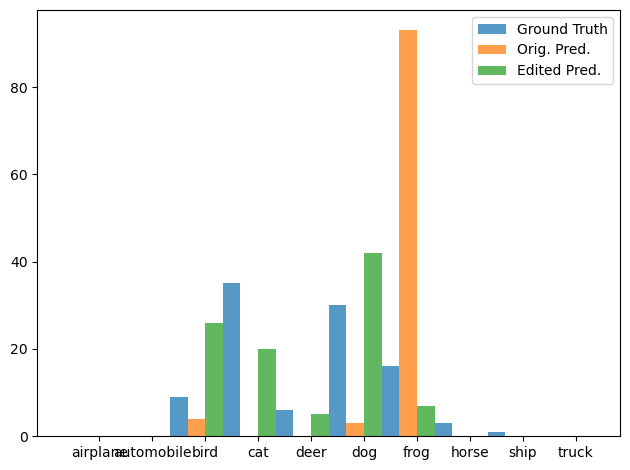

{'original_distribution': array([ 0,  0,  4,  0,  0,  3, 93,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 26, 20,  5, 42,  7,  0,  0,  0]), 'n_changed_to_target': 39, 'n_unaffected': 14}
Data type: logits anchor_type: value
label bins (10): [ 0  0 10 18 26 35  5  3  3  0]
prediction bins (10): [ 0  0 41  8  4 45  2  0  0  0]
new prediction bins: 10


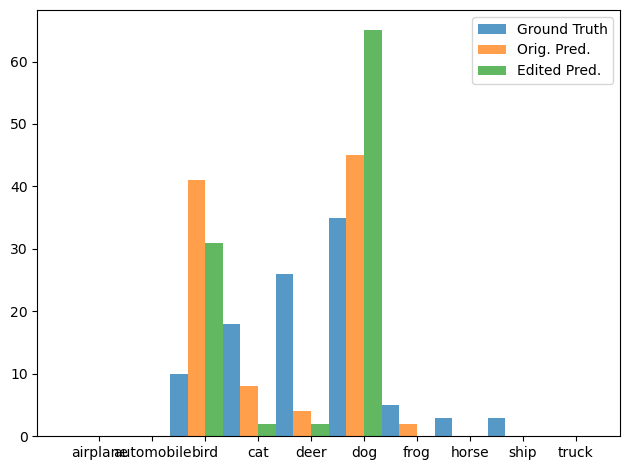

{'original_distribution': array([ 0,  0, 41,  8,  4, 45,  2,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 31,  2,  2, 65,  0,  0,  0,  0]), 'n_changed_to_target': 20, 'n_unaffected': 80}
{'features_key': {'original_distribution': array([ 0,  0,  2,  0,  0,  3, 95,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 34, 16,  0, 38, 12,  0,  0,  0]), 'n_changed_to_target': 35, 'n_unaffected': 17}, 'features_value': {'original_distribution': array([ 0,  0, 39, 10,  3, 45,  3,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 30,  7,  1, 62,  0,  0,  0,  0]), 'n_changed_to_target': 17, 'n_unaffected': 83}, 'logits_key': {'original_distribution': array([ 0,  0,  4,  0,  0,  3, 93,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 26, 20,  5, 42,  7,  0,  0,  0]), 'n_changed_to_target': 39, 'n_unaffected': 14}, 'logits_value': {'original_distribution': array([ 0,  0, 41,  8,  4, 45,  2,  0,  0,  0]), 'edited_distribution': array([ 0,  0, 31,  2,  2, 65,  0,  0,  0,  0]), 'n_change

In [6]:
# See how predictions change for all 4 sets of neighbors (key-features, key-logits, value-features, value-logits)
prediction_changes_results = {}
for data_type in ['features', 'logits']:
    for anchor_type in [0, 1]: # 0 : key, 1 : value
        print("Data type: {} anchor_type: {}".format(data_type, 'key' if anchor_type==0 else 'value'))
        image_paths = pre_edit_knn[data_type]['image_paths'][anchor_type]
        labels = pre_edit_knn[data_type]['labels'][anchor_type]
        predictions = pre_edit_knn[data_type]['predictions'][anchor_type]
        results = predict_and_compare(
            image_paths=image_paths,
            labels=labels,
            class_list=class_list,
            target=5,
            predictions=predictions,
            model=edited_model,
            device=device)
        print(results)
        key = "{}_{}".format(data_type, 'key' if anchor_type==0 else 'value')
        prediction_changes_results[key] = results
        
# Obtain edited model's prediction for the key and value images
prediction_changes_results['edited_A_prediction'] = np.argmax(post_edit_key_logits)
prediction_changes_results['edited_B_prediction'] = np.argmax(post_edit_value_logits)


knn_analysis_results["prediction_changes"] = prediction_changes_results
        
print(prediction_changes_results)

### Given neighbors of the value image, find distances from key

In [7]:
# from scipy.spatial import distance

distance_results = {
    'features': {},
    'logits': {}
}

# def calculate_distance(u, v, metric='minkowski'):
#     if metric == 'minkowski':
#         return distance.minkowski(u, v)
#     else:
#         raise ValueError("Distance metric {} not supported.".format(metric))

In [11]:
# # Sanity check that A's neighbors get the correct distances in feature space

# features_results = pre_edit_knn['images']
# knn_distances = features_results['distances'][0]
# knn_image_paths = features_results['image_paths'][0]
# flattened_key_image = np.copy(key_image)
# flattened_key_image = flattened_key_image.flatten()

# images = []
# for path in knn_image_paths:
    
#     image = load_image(path, resize=IMAGE_SIZE)
#     image = image.flatten()
#     images.append(image)

# distances = calculate_distances(
#     vectors=images,
#     anchor=flattened_key_image
# )
# for knn_dist, minkowski_dist in zip(knn_distances, distances):
#     assert np.abs(knn_dist - minkowski_dist) < 1e-5

NameError: name 'key_image' is not defined

In [8]:
# Distance between key and value before edit

pre_edit_key_val_feature_dist = calculate_distance(pre_edit_key_features, pre_edit_value_features)
post_edit_key_val_feature_dist = calculate_distance(post_edit_key_features, post_edit_value_features)
log("Distance between key and value in feature space before edit: {} after edit: {}".format(
    pre_edit_key_val_feature_dist, post_edit_key_val_feature_dist), log_path)

pre_edit_key_val_logit_dist = calculate_distance(pre_edit_key_logits, pre_edit_value_logits)
post_edit_key_val_logit_dist = calculate_distance(post_edit_key_logits, post_edit_value_logits)
log("Distance between key and value in logit space before edit: {} after edit: {}".format(
    pre_edit_key_val_logit_dist, post_edit_key_val_logit_dist), log_path)

distance_results['features']['A_B'] = (pre_edit_key_val_feature_dist, post_edit_key_val_feature_dist)
distance_results['logits']['A_B'] = (pre_edit_key_val_logit_dist, post_edit_key_val_logit_dist)

Distance between key and value in feature space before edit: 2.034398317337036 after edit: 1.5898463726043701
Distance between key and value in logit space before edit: 3.038433074951172 after edit: 1.9667236804962158


### Key Image Neighbor Analysis

Find the top neighbors of the key image before the edit
Calculate the distances in the feature and logit space to the value image before and after the edit and see how they differ.

How to take into account the changes in the value image's representation in the feature and logit space due to the edit as well?

### Comparing Key Image with Value Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [9]:
log("Key image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_key_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_key_features)
mean_pre_key_to_pre_value_neighbors_features_distances = np.mean(pre_key_to_pre_value_neighbors_features_distances)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_key_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_key_features)

mean_post_key_to_pre_value_neighbors_edited_features_distances = np.mean(post_key_to_pre_value_neighbors_edited_features_distances)

log("Features", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
# log(str(pre_key_to_pre_value_neighbors_features_distances), log_path)
log("Average distance: {}".format(mean_pre_key_to_pre_value_neighbors_features_distances), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
# log(str(post_key_to_pre_value_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(mean_post_key_to_pre_value_neighbors_edited_features_distances), log_path)

log("", log_path)

# Store results
distance_results['features']['A_Bn'] = (mean_pre_key_to_pre_value_neighbors_features_distances, mean_post_key_to_pre_value_neighbors_edited_features_distances)
    

Key image with value neighbors
Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
Average distance: 2.6549775874614716
Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
Average distance: 2.0513778084516527



### Comparing Key Image with Value Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [10]:
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate distances between key and neighbors of value before the edit
pre_key_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_key_logits)
mean_pre_key_to_pre_value_neighbors_logits_distances = np.mean(pre_key_to_pre_value_neighbors_logits_distances)

pre_key_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_key_logits)
mean_pre_key_to_pre_value_neighbors_edited_logits_distances = np.mean(pre_key_to_pre_value_neighbors_edited_logits_distances)

log("Logits", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
# log(str(pre_key_to_pre_value_neighbors_logits_distances), log_path, log_path)
log("Average distance: {}".format(mean_pre_key_to_pre_value_neighbors_logits_distances), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
# log(str(pre_key_to_pre_value_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(mean_pre_key_to_pre_value_neighbors_edited_logits_distances), log_path)

log("", log_path)
log("---***---", log_path)

# Add to results
distance_results['logits']['A_Bn'] = (mean_pre_key_to_pre_value_neighbors_logits_distances, mean_pre_key_to_pre_value_neighbors_edited_logits_distances)

Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
Average distance: 3.8648651254177095
Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
Average distance: 2.5641510564088823

---***---


### Comparing Value Image with Key Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [11]:
# Load images that are the pre-edit neighbors of key
# Only looking at features
log("Value Image with Key Neighbors", log_path)
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_value_features)
mean_pre_value_to_pre_key_neighbors_features_distances = np.mean(pre_value_to_pre_key_neighbors_features_distances)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_value_features)
mean_post_value_to_pre_key_neighbors_edited_features_distances = np.mean(post_value_to_pre_key_neighbors_edited_features_distances)

log("Features", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
# log(str(pre_value_to_pre_key_neighbors_features_distances), log_path)
log("Average distance: {}".format(mean_pre_value_to_pre_key_neighbors_features_distances), log_path)
log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
# log(str(post_value_to_pre_key_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(mean_post_value_to_pre_key_neighbors_edited_features_distances), log_path)

log("", log_path)

distance_results['features']['B_An'] = (mean_pre_value_to_pre_key_neighbors_features_distances, mean_post_value_to_pre_key_neighbors_edited_features_distances)


Value Image with Key Neighbors
Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
Average distance: 2.6767392694950103
Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
Average distance: 2.3805379009246828



### Comparing Value Image with Key Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [12]:
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_logits_images)

# Move  logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_value_logits)
mean_pre_value_to_pre_key_neighbors_logits_distances = np.mean(pre_value_to_pre_key_neighbors_logits_distances)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_value_logits)
mean_post_value_to_pre_key_neighbors_edited_logits_distances = np.mean(post_value_to_pre_key_neighbors_edited_logits_distances)

log("logits", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
# log(str(pre_value_to_pre_key_neighbors_logits_distances), log_path)
log("Average distance: {}".format(mean_pre_value_to_pre_key_neighbors_logits_distances), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
# log(str(post_value_to_pre_key_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(mean_post_value_to_pre_key_neighbors_edited_logits_distances), log_path)

distance_results['logits']['B_An'] = (mean_pre_value_to_pre_key_neighbors_logits_distances, mean_post_value_to_pre_key_neighbors_edited_logits_distances)


logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
Average distance: 3.8959230613708495
Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
Average distance: 3.08479771733284


### Comparing Key Image with Key Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model


In [13]:
log("Key image with key neighbors", log_path)
# Load images that are the pre-edit neighbors of key
# Only looking at features
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
# pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of key before the edit 
pre_key_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_key_features)
mean_pre_key_to_pre_key_neighbors_features_distances = np.mean(pre_key_to_pre_key_neighbors_features_distances)

# Calculate feature distances between key post edit and key's original neighbors via post edit model
post_key_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_key_features)

mean_post_key_to_pre_key_neighbors_edited_features_distances = np.mean(post_key_to_pre_key_neighbors_edited_features_distances)

log("Features", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
# log(str(pre_key_to_pre_key_neighbors_features_distances), log_path)
log("Average distance: {}".format(mean_pre_key_to_pre_key_neighbors_features_distances), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
# log(str(post_key_to_pre_key_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(mean_post_key_to_pre_key_neighbors_edited_features_distances), log_path)

log("", log_path)

distance_results['features']['A_An'] = (mean_pre_key_to_pre_key_neighbors_features_distances, mean_post_key_to_pre_key_neighbors_edited_features_distances)


Key image with key neighbors
Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
Average distance: 1.3485839557647705
Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
Average distance: 1.3744402420520783



### Comparing Key Image with Key Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [14]:
log("Key image with key neighbors", log_path)
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_model(pre_edit_key_neighbor_logits_images)

# Move logits and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of key before the edit 
pre_key_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_key_logits)
mean_pre_key_to_pre_key_neighbors_logits_distances = np.mean(pre_key_to_pre_key_neighbors_logits_distances)

# Calculate feature distances between key post edit and key's original neighbors via post edit model
post_key_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_key_logits)
mean_post_key_to_pre_key_neighbors_edited_logits_distances = np.mean(post_key_to_pre_key_neighbors_edited_logits_distances)

log("Logits", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
# log(str(pre_key_to_pre_key_neighbors_logits_distances), log_path)
log("Average distance: {}".format(mean_pre_key_to_pre_key_neighbors_logits_distances), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
# log(str(post_key_to_pre_key_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(mean_post_key_to_pre_key_neighbors_edited_logits_distances), log_path)

log("", log_path)
distance_results['logits']['A_An'] = (mean_pre_key_to_pre_key_neighbors_logits_distances, mean_post_key_to_pre_key_neighbors_edited_logits_distances)

Key image with key neighbors
Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
Average distance: 1.840430910587311
Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
Average distance: 1.867742674946785



### Comparing Value Image with Value Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model

In [15]:
log("Value image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for value image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
# pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between value and neighbors of value before the edit 
pre_value_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_value_features)
mean_pre_value_to_pre_value_neighbors_features_distances = np.mean(pre_value_to_pre_value_neighbors_features_distances)

# Calculate feature distances between value post edit and value's original neighbors via post edit model
post_value_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_value_features)
mean_post_value_to_pre_value_neighbors_edited_features_distances = np.mean(post_value_to_pre_value_neighbors_edited_features_distances)

log("Features", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
# log(str(pre_value_to_pre_value_neighbors_features_distances), log_path)
log("Average distance: {}".format(mean_pre_value_to_pre_value_neighbors_features_distances), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
# log(str(post_value_to_pre_value_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(mean_post_value_to_pre_value_neighbors_edited_features_distances), log_path)

log("", log_path)
distance_results['features']['B_Bn'] = (mean_pre_value_to_pre_value_neighbors_features_distances, mean_post_value_to_pre_value_neighbors_edited_features_distances)

Value image with value neighbors
Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
Average distance: 1.5051102894544601
Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
Average distance: 1.3892899119853974



### Comparing Value Image with Value Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model

In [16]:
log("Value image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(torch.from_numpy(load_image(path, data_format='CHW', resize=IMAGE_SIZE)))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for value image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move logits and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between value and neighbors of value before the edit 
pre_value_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_value_logits)
mean_pre_value_to_pre_value_neighbors_logits_distances = np.mean(pre_value_to_pre_value_neighbors_logits_distances)

# Calculate feature distances between value post edit and value's original neighbors via post edit model
post_value_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_value_logits)
mean_post_value_to_pre_value_neighbors_edited_logits_distances = np.mean(post_value_to_pre_value_neighbors_edited_logits_distances)

log("Logits", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
# log(str(pre_value_to_pre_value_neighbors_logits_distances), log_path)
log("Average distance: {}".format(mean_pre_value_to_pre_value_neighbors_logits_distances), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
# log(str(post_value_to_pre_value_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(mean_post_value_to_pre_value_neighbors_edited_logits_distances), log_path)

log("", log_path)

distance_results['logits']['B_Bn'] = (mean_pre_value_to_pre_value_neighbors_logits_distances, mean_post_value_to_pre_value_neighbors_edited_logits_distances)

Value image with value neighbors
Logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
Average distance: 2.014631634950638
Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
Average distance: 1.7149735617637634



### Save results

In [17]:
knn_analysis_results['distance_results'] = distance_results
print(knn_analysis_results.keys())
torch.save(knn_analysis_results, save_results_path)
print("Saved knn analysis results to {}".format(save_results_path))

dict_keys(['prediction_changes', 'distance_results'])
Saved knn analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0110_120730/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth
